## 1.3 Milvus 核心架构与组件解析
### Milvus 的分布式架构概览
按照数据平面和控制平面分解的原则，Milvus 由四层组成：访问层、协调器服务、工作节点和存储。这些层在扩展或灾难恢复时相互独立。
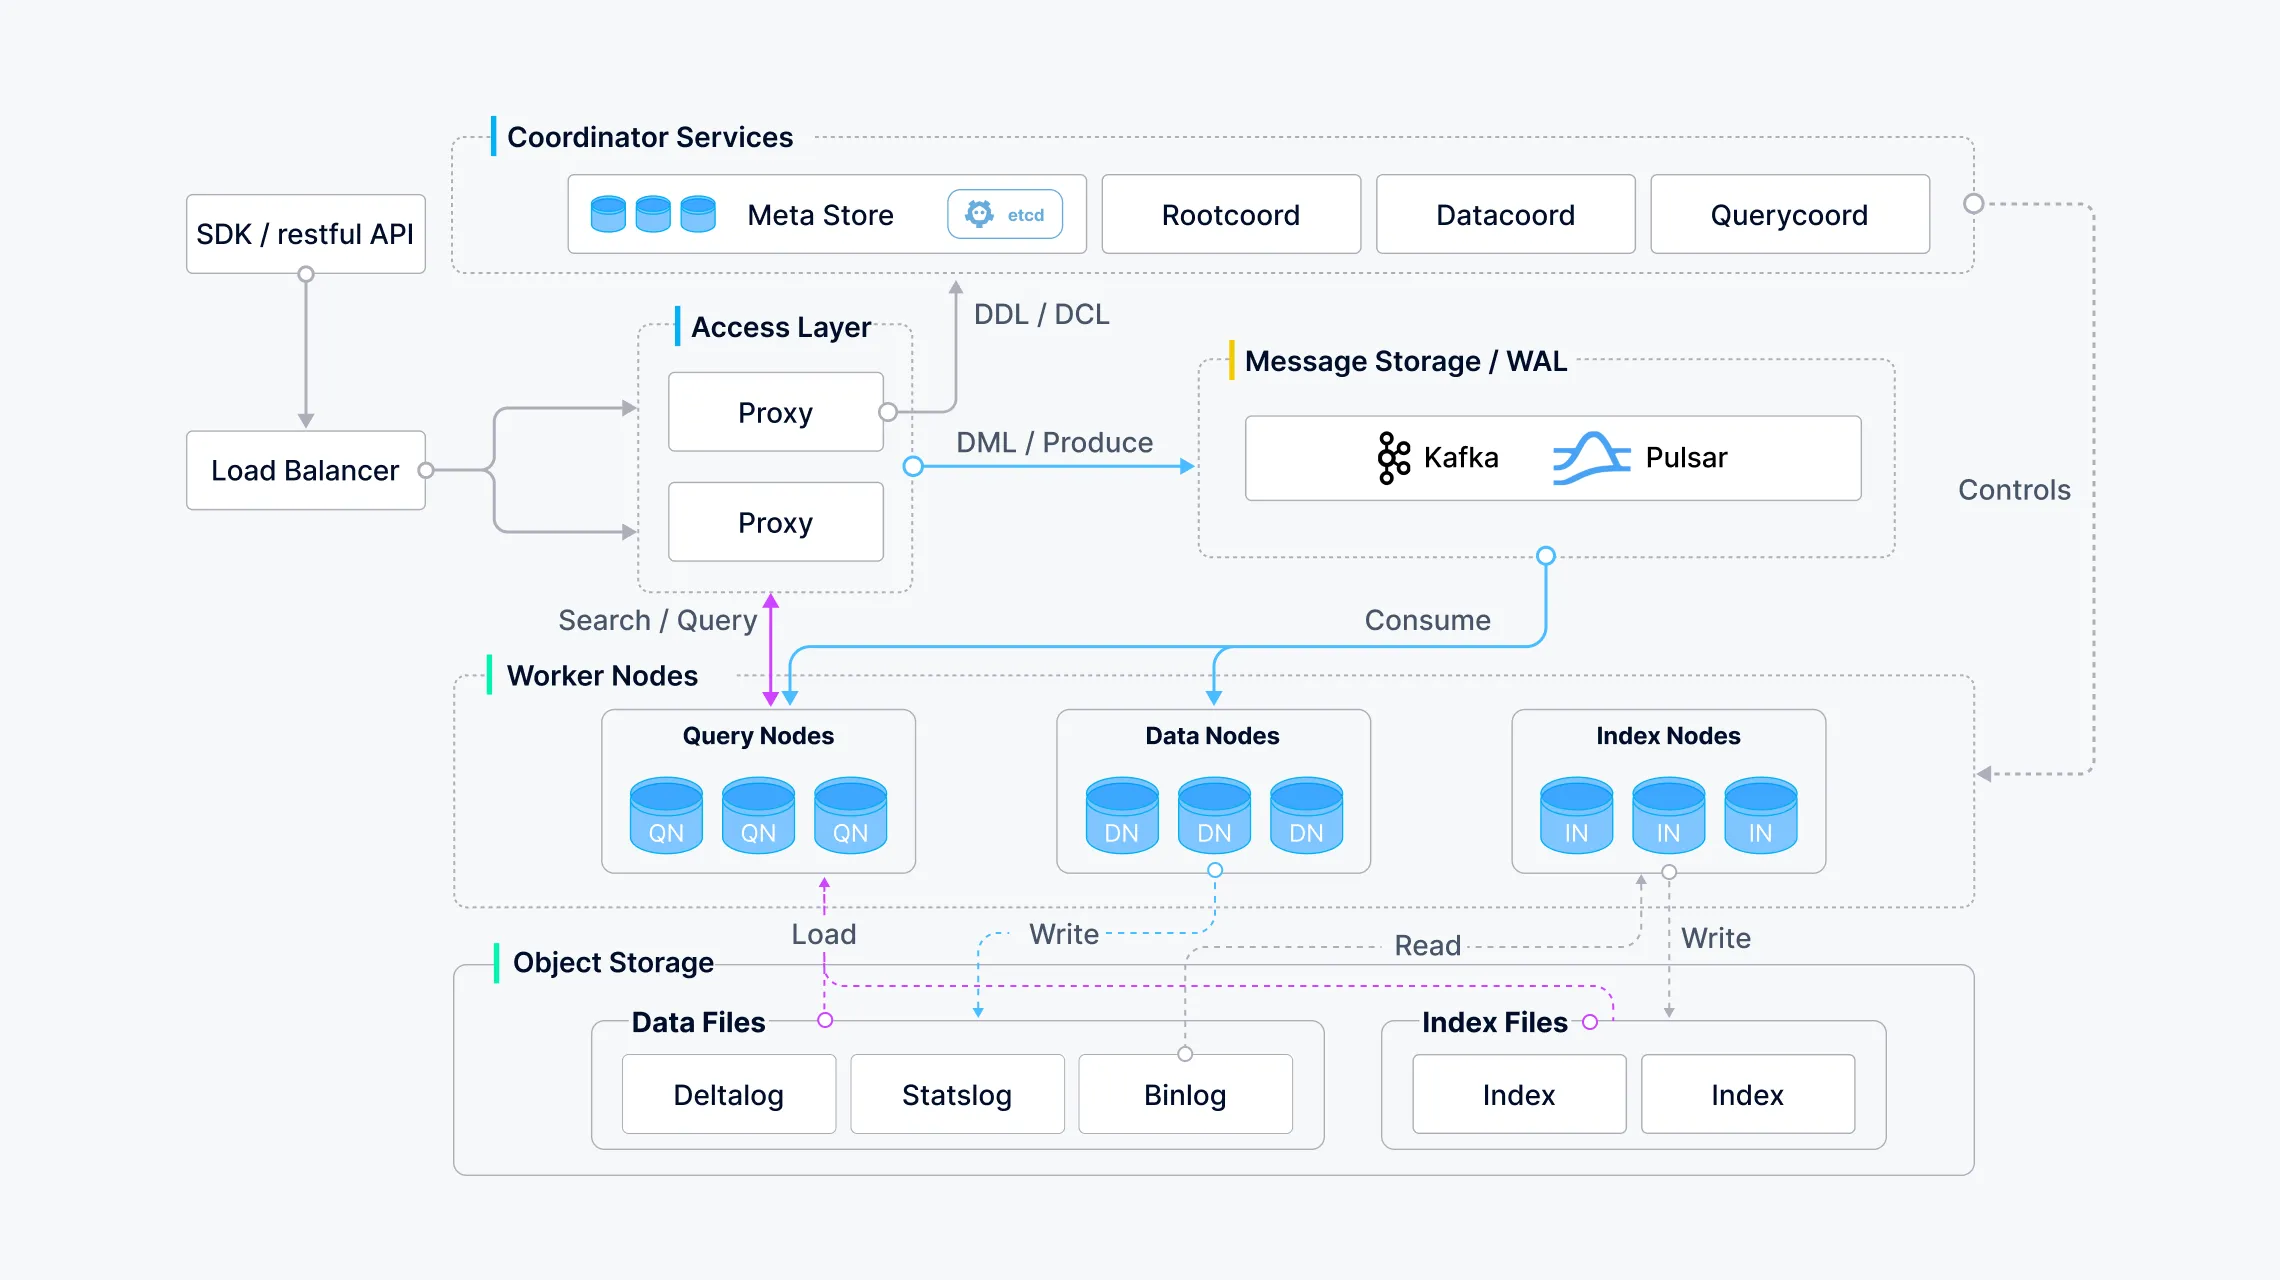

### 核心组件功能详解
#### 访问层
+ **Proxy**：请求入口，负载均衡
    - 由一组无状态代理组成，是系统的前端层，也是用户的终端。
    - 使用 Nginx、Kubernetes Ingress、NodePort 和 LVS 等负载均衡组件提供统一的服务地址。

#### 协调器服务
> 协调器服务是系统的大脑，负责将任务分配给工作节点。

+ **Rootcoord**：根协调器，管理拓扑和任务
    - 处理数据定义语言（DDL）和数据控制语言（DCL）请求，如创建或删除 Collections、分区或索引。
    - 管理 TSO（时间戳 Oracle）和时间刻度签发。
+ **Querycoord**：查询协调器，管理查询节点和索引加载
    - 负责管理查询节点的拓扑结构和负载平衡，以及从增长网段到封存网段的切换。
+ **Datacoord**：数据协调器，管理数据段
    - 管理数据节点和索引节点的拓扑结构，维护元数据，并触发刷新、压缩和索引构建以及其他后台数据操作。

#### 工作节点
> 工作节点是系统的手臂和腿。它们遵从协调器服务的指令，执行来自代理的数据操作语言（DML）命令。

+ **Data Nodes**：写入节点，处理数据写入和持久化
    - 通过订阅**日志代理**检索增量日志数据并将其转化为不断增长的片段，从**对象存储**中加载历史数据，并在向量和标量数据之间运行混合搜索。
+ **Query Nodes**：查询节点，加载数据和索引，执行搜索/查询
    - 通过订阅**日志代理**检索增量日志数据，处理突变请求，将日志数据打包成日志快照并存储在**对象存储**中。
+ **Index Nodes**：索引构建节点，执行索引构建任务
    - 索引节点构建索引。索引节点不需要常驻内存，可以使用无服务器框架来实现。

#### 存储
> 存储是系统的骨骼，负责数据持久性。

+ **元存储**：
    - 存储元数据的快照，如 Collections Schema 和消息消耗检查点。
    - 元数据的存储要求极高的可用性、强一致性和事务支持，因此 Milvus 选择 etcd 作为元存储。
    - Milvus 还使用 etcd 进行服务注册和健康检查。
+ **对象存储**：
    - 用于存储日志快照文件、标量和向量数据的索引文件以及中间查询结果。
    - Milvus 使用 MinIO 作为对象存储，可随时部署在 AWS S3 和 Azure Blob 这两个全球最流行、最具成本效益的存储服务上。
    - 然而，对象存储的访问延迟较高，并按查询次数收费。为了提高性能并降低成本，Milvus 计划在基于内存或固态硬盘的缓存池上实现冷热数据分离。
+ **日志代理**：
    - 日志代理是一个支持回放的发布子系统。它负责流数据持久化和事件通知。
    - 当工作节点从系统故障中恢复时，它能通过回放消息存储确保增量数据的完整性。
    - Milvus 集群使用 Pulsar 作为日志代理；Milvus 单机使用 RocksDB 作为日志代理。此外，日志代理也可以替换为 Kafka 等流式数据存储平台。